## Семинар 6: "Архитектуры и transfer learning"

ФИО:Белозёров Михаил Сергеевич

In [1]:
from __future__ import print_function, division
from scipy.signal import convolve
from skimage import io, transform
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import time
import torch
import torchvision.models as models

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на занятии номер 3 с помощью Transfer Learning

### Часть 1: Inference

Пропустите картинки с лицами через предобученную на Imagenet "сверточную часть" AlexNet или VGG сетей и обучите на полученных данных один полносвязный слой.

In [2]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.ix[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.ix[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToRGB(object):
    """Convert grayscale to semiRGB"""
    def __call__ (self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': np.stack((image,)*3),
                'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        img, marks = sample['image'], sample['landmarks']
        h, w = img.shape[:2]
        new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(img, (new_h, new_w))
        landmarks = marks * [new_w / w, new_h / h]
        return {'image': img, 'landmarks': landmarks}

In [10]:
def show_landmarks(img, marks):
    print (img.shape)
    plt.imshow(img, cmap='gray')
    plt.scatter(marks[:, 0], marks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  

def draw_one (dl, model):
    for batch_idx, sample in enumerate(dl):
        x = sample['image']
        x = Variable (x.type (torch.FloatTensor))
        y_pred = model(x)
        y_pred = y_pred.view (sample['landmarks'].size ())
        show_landmarks (sample['image'][0][0].numpy (), y_pred.data[0].numpy ())
        break

In [4]:
transformed_dataset_train = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                           root_dir='dataset/train/',
                                           transform=transforms.Compose([
                                               Rescale ((224,224)),
                                               ToRGB (),
                                               ToTensor()
                                           ]))

dataloader = DataLoader(transformed_dataset_train, batch_size=50,
                        shuffle=True, )


transformed_dataset_test = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                           root_dir='dataset/test/',
                                           transform=transforms.Compose([
                                               Rescale ((224,224)),
                                               ToRGB (),
                                               ToTensor()
                                           ]))

dataloader_test = DataLoader(transformed_dataset_test, batch_size=50,
                        shuffle=True, )

In [5]:
model_conv = models.vgg11(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.classifier[0].in_features
layers = [nn.Linear (num_ftrs, 4096), nn.ReLU (), nn.Linear (4096, 136)]
model_conv.classifier = nn.Sequential (*layers)

In [6]:
loss_fn = nn.MSELoss ()
optimizer = torch.optim.Adam(model_conv.classifier.parameters(), lr=0.0001) 

loss_m = []
epoch_num = []

 Epoch: 19, Batch:124/125, Current loss: 19.1222667694 Iteration time: 8.48852863178, Elapsed:21693.19502, Prediction:8.4885286317819

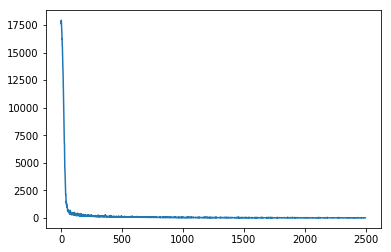


 0.3581  0.5046  0.5142  ...   0.4742  0.4274  0.2941
 0.5022  0.7073  0.7200  ...   0.6634  0.5974  0.4110
 0.5046  0.7100  0.7205  ...   0.6619  0.5945  0.4086
          ...             ⋱             ...          
 0.1393  0.1928  0.1863  ...   0.2904  0.2944  0.2113
 0.1441  0.2007  0.1978  ...   0.2911  0.2959  0.2125
 0.1040  0.1453  0.1441  ...   0.2081  0.2117  0.1521
[torch.DoubleTensor of size 224x224]

(224, 224)


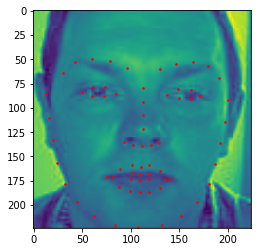

In [7]:
start_time_all = time.time()
max_epoh = 20
data_len = len (dataloader)
iter_t = []
for epoch in range (max_epoh):
    for i, sample in enumerate (dataloader):
        start_time = time.time()

        optimizer.zero_grad ()
        x = sample['image'].type (torch.FloatTensor)
        target = sample['landmarks']
        x_batch = Variable (x)
        target = Variable (target.view (target.size (0), -1), requires_grad=False)
        y_batch = target.type (torch.FloatTensor)
        
        output = model_conv (x_batch)
        loss = loss_fn(output, y_batch)
        loss_m.append (loss.data.mean ())

        loss.backward()
        optimizer.step()

        new_time = time.time()
        elapsed_time = new_time - start_time_all
        iter_t.append (new_time - start_time)
        it_time = np.mean (iter_t)
        pred_time = (max_epoh - epoch - 1) * data_len * it_time + (data_len - i) * it_time
        
        sys.stdout.write (('\r Epoch: {}, Batch:{}/{}, Current loss: {} Iteration time: {}, Elapsed:{}, Prediction:{}')
                          .format (epoch, i, data_len, loss_m[-1], it_time, elapsed_time, pred_time))        
    epoch_num.append (len (loss_m))

plt.plot (loss_m)
plt.show ()

draw_one (dataloader, model_conv)

In [27]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
epoch =1    
save_checkpoint({
            'epoch': epoch,
            'state_dict': model_conv.state_dict(),
            'optimizer' : optimizer.state_dict(),
        })

In [26]:
print (np.mean (loss_m[500:]))

44.2068819108


In [8]:
test_error = []

In [9]:
for sample in dataloader_test:
    x = sample['image'].type (torch.FloatTensor)
    target = sample['landmarks']
    x_batch = Variable (x)
    target = Variable (target.view (target.size (0), -1), requires_grad=False)
    y_batch = target.type (torch.FloatTensor)

    output = model_conv (x_batch)
    loss = loss_fn(output, y_batch)
    test_error.append (loss.data.mean ())

error mean: 40.7682700753


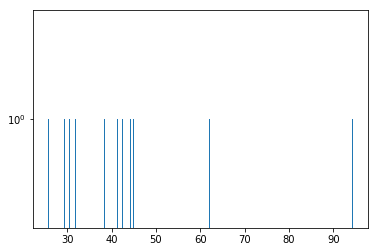

In [17]:
print ('error mean:', np.mean (test_error))
plt.hist (test_error, log=True, bins=1000)
plt.show ()

(224, 224)


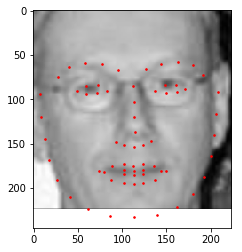

In [25]:
draw_one (dataloader_test, model_conv)

### Часть 2 (опциональная)

Попробуйте обучить одну из архитектур на датасете. Сравните результаты с пунктом 1  

In [5]:
model_conv_my = models.vgg11(pretrained=False)    
num_ftrs = model_conv_my.classifier[0].in_features
layers = [nn.Linear (num_ftrs, 4096), nn.ReLU (), nn.Linear (4096, 136)]
model_conv_my.classifier = nn.Sequential (*layers)

In [6]:
loss_fn = nn.MSELoss ()
optimizer = torch.optim.Adam(model_conv_my.parameters(), lr=0.0001) 

loss_m = []
epoch_num = []

In [7]:
start_time_all = time.time()
max_epoh = 20
data_len = len (dataloader)
iter_t = []
for epoch in range (max_epoh):
    for i, sample in enumerate (dataloader):
        start_time = time.time()

        optimizer.zero_grad ()
        x = sample['image'].type (torch.FloatTensor)
        target = sample['landmarks']
        x_batch = Variable (x)
        target = Variable (target.view (target.size (0), -1), requires_grad=False)
        y_batch = target.type (torch.FloatTensor)
        
        output = model_conv_my (x_batch)
        loss = loss_fn(output, y_batch)
        loss_m.append (loss.data.mean ())

        loss.backward()
        optimizer.step()

        new_time = time.time()
        elapsed_time = new_time - start_time_all
        iter_t.append (new_time - start_time)
        it_time = np.mean (iter_t)
        pred_time = (max_epoh - epoch - 1) * data_len * it_time + (data_len - i) * it_time
        
        sys.stdout.write (('\r Epoch: {}, Batch:{}/{}, Current loss: {} Iteration time: {}, Elapsed:{}, Prediction:{}')
                          .format (epoch, i, data_len, loss_m[-1], it_time, elapsed_time, pred_time))        
    epoch_num.append (len (loss_m))

plt.plot (loss_m)
plt.show ()

draw_one (dataloader, model_conv_my)

 Epoch: 7, Batch:30/125, Current loss: 191.130767822 Iteration time: 32.2532675085, Elapsed:29494.331435, Prediction:51443.961676974

KeyboardInterrupt: 

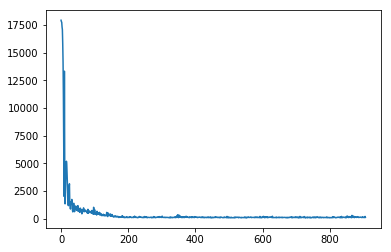

(224, 224)


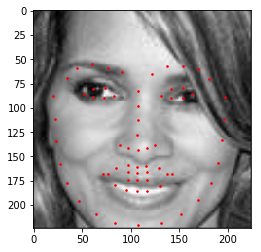

In [12]:
plt.plot (loss_m)
plt.show ()

draw_one (dataloader, model_conv_my)

In [14]:
test_error = []

In [16]:
for i, sample in enumerate (dataloader_test):
    x = sample['image'].type (torch.FloatTensor)
    target = sample['landmarks']
    x_batch = Variable (x)
    target = Variable (target.view (target.size (0), -1), requires_grad=False)
    y_batch = target.type (torch.FloatTensor)

    output = model_conv_my (x_batch)
    loss = loss_fn(output, y_batch)
    test_error.append (loss.data.mean ())
    sys.stdout.write ('\rBatch: {}/{}'.format (i, len (dataloader_test)))

Batch: 31/32

error mean: 109.993323607


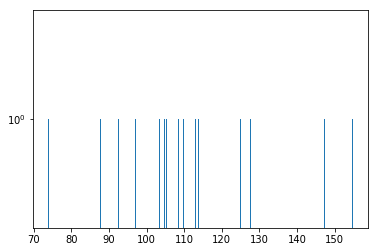

In [17]:
print ('error mean:', np.mean (test_error))
plt.hist (test_error, log=True, bins=1000)
plt.show ()

(224, 224)


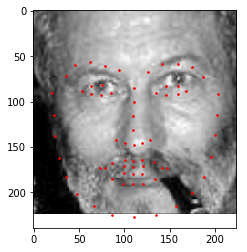

In [18]:
draw_one (dataloader_test, model_conv_my)

### время обучения увеличилось в 4 раза, а ошибка, как можно видеть по графику, перестала падать раньше и в среднем стала больше, чем у предобученой модели. 

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: